In [282]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
from ggplot import *
from sys import float_info

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools

import sys
sys.path.append("../..")
from networkentropy import network_energy as ne, network_energy_gradient as neg

In [303]:
results = []
graphs = []
methods = ['graph', 'laplacian', 'randic']
generators = ['random', 'smallworld', 'waxman', 'powerlaw']
p_max = 4
p_values = list(range(1,p_max))

def create_graph(p, generator, p_max, num_modes=100):
    if generator == 'random':
        return nx.erdos_renyi_graph(n=num_nodes, p=p/(p_max*10))
    elif generator == 'smallworld':
        return nx.watts_strogatz_graph(n=num_nodes, k=4, p=p/p_max)
    elif generator == 'waxman':
        return nx.waxman_graph(n=num_nodes, alpha=p/p_max, beta=0.1)
    elif generator == 'powerlaw':
        return nx.powerlaw_cluster_graph(n=num_nodes, m=3, p=p/(p_max*10))
    else:
        raise ValueError('Generator: {} does not exist'.format(generator))
        
p_values_generators = list(itertools.product(p_values, generators))
for p, generator in tqdm(p_values_generators):
    G = create_graph(p, generator, p_max)
    graphs.append((p, generator, G))
    for method in methods:
        graph_gradients = list(neg.get_energy_gradients(G, method).values())
        for gradient in graph_gradients:
            results.append((p, generator, method, gradient))
            
p, generator, method, gradients = map(list, zip(*results))
df = pd.DataFrame({'p': p, 'generator': generator, 'method': method, 'gradients': gradients})

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.87it/s]


### Visualization of energy gradients distributions in synthetic networks

Every network has been created with a few different parameters

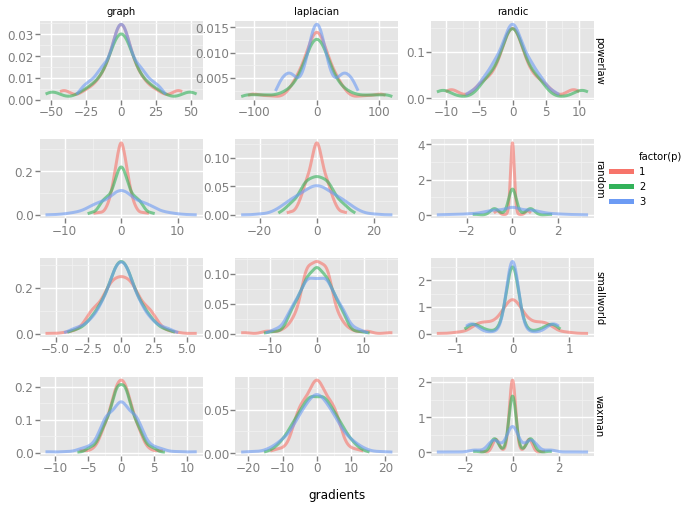

<ggplot: (148358647465)>

In [304]:
ggplot(aes(x='gradients', color='factor(p)'), data=df) + \
geom_density(alpha=0.6, size=3) + \
facet_grid('generator', 'method', scales = "free")

In [293]:
graphs_with_data = {}
min_energies = {}
max_energies = {}
min_gradients = {}
max_gradients = {}
for i, (p, generator, G) in enumerate(graphs):
    neg.get_graph_with_energy_data(G, methods=methods, copy=False)
    for method in methods:
        energies = np.array(list(nx.get_node_attributes(G, '{}_energy'.format(method)).values()))
        gradients = np.array([np.abs(g) for g in nx.get_edge_attributes(G, '{}_gradient'.format(method)).values()])
        graphs_with_data[(p, generator, method)] = (energies, gradients, G)
        min_energies[(p, generator, method)] = np.min(energies)
        max_energies[(p, generator, method)] = np.max(energies)
        min_gradients[(p, generator, method)] = np.min(gradients)
        max_gradients[(p, generator, method)] = np.max(gradients)
        
def get_vmin_vmax(min_dict, max_dict, vstrategy="", p=None, generator=None, method=None):
    strategies = vstrategy.split('+')
    vp_values, vmethods, vgenerators = p_values, methods, generators
    if 'p' in strategies:
        vp_values = [p]
    if 'method' in strategies:
        vmethods = [method]
    if 'generator' in strategies:
        vgenerators = [generator]

    min_value = float_info.max
    max_value = float_info.min
    for p, m, g in itertools.product(p_values, methods, generators):
        if p in vp_values and g in vgenerators and m in vmethods:
            if min_dict[(p, g, m)] < min_value:
                min_value = min_dict[(p, g, m)]
            if max_dict[(p, g, m)] > max_value:
                max_value = max_dict[(p, g, m)]
    return min_value, max_value

def get_vmin_vmax_energy(vstrategy, p, generator, mathod):
    return get_vmin_vmax(min_energies, max_energies, vstrategy, p, generator, mathod)

def get_vmin_vmax_gradient(vstrategy, p, generator, mathod):
    return get_vmin_vmax(min_gradients, max_gradients, vstrategy, p, generator, mathod)
            
def draw_network(p, generator, method, vstrategy=''):
    vmin, vmax = get_vmin_vmax_energy(vstrategy, p, generator, method)
    edge_vmin, edge_vmax = get_vmin_vmax_gradient(vstrategy, p, generator, method)
    energies, gradients, G = graphs_with_data[(p, generator, method)]
    pos = nx.layout.kamada_kawai_layout(G)
    plt.figure(i, figsize=(18,12))
    nodes = nx.draw_networkx_nodes(G, pos, node_color=energies, cmap=plt.cm.coolwarm, 
                                   vmin=vmin, vmax=vmax, with_labels=False)
    edges = nx.draw_networkx_edges(G, pos, edge_vmin=edge_vmin, edge_vmax=edge_vmax, 
                                   edge_color=gradients, edge_cmap=plt.cm.Reds, width=2, with_labels=False)
    edges_cbar = plt.colorbar(edges)
    edges_cbar.ax.set_title('gradient')
    nodes_cbar = plt.colorbar(nodes)
    nodes_cbar.ax.set_title('energy')
    plt.title('Generator: {}, Method: {}, p: {}'.format(generator, method, p))
    plt.axis('off')
    plt.show()

### Visualization of graph energy and graph energy gradients in sythetic networks

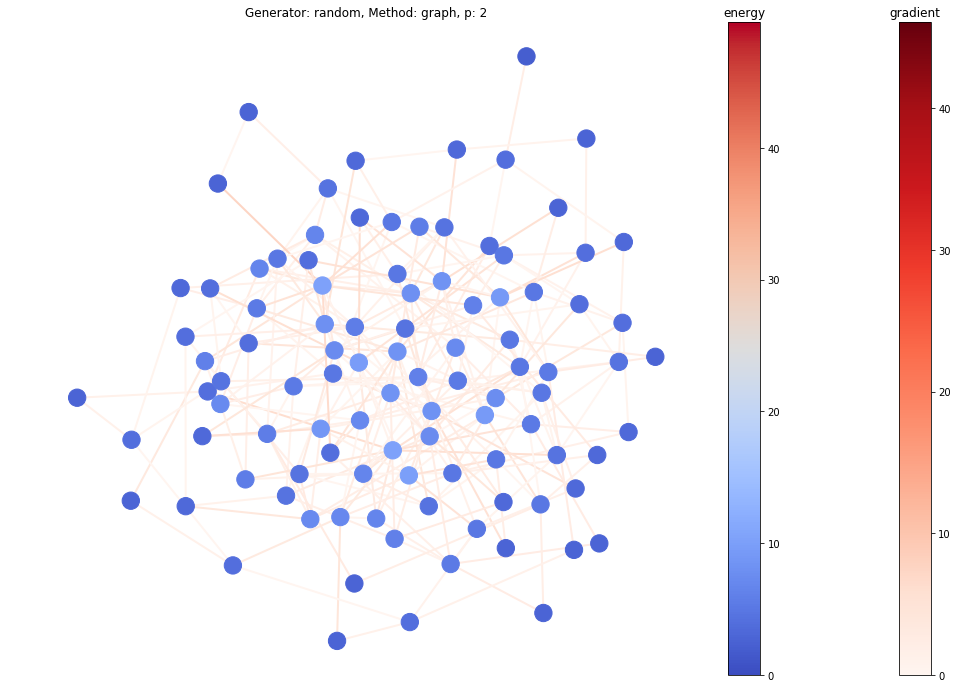

In [294]:
draw_network(2, 'random', 'graph', 'p+method')

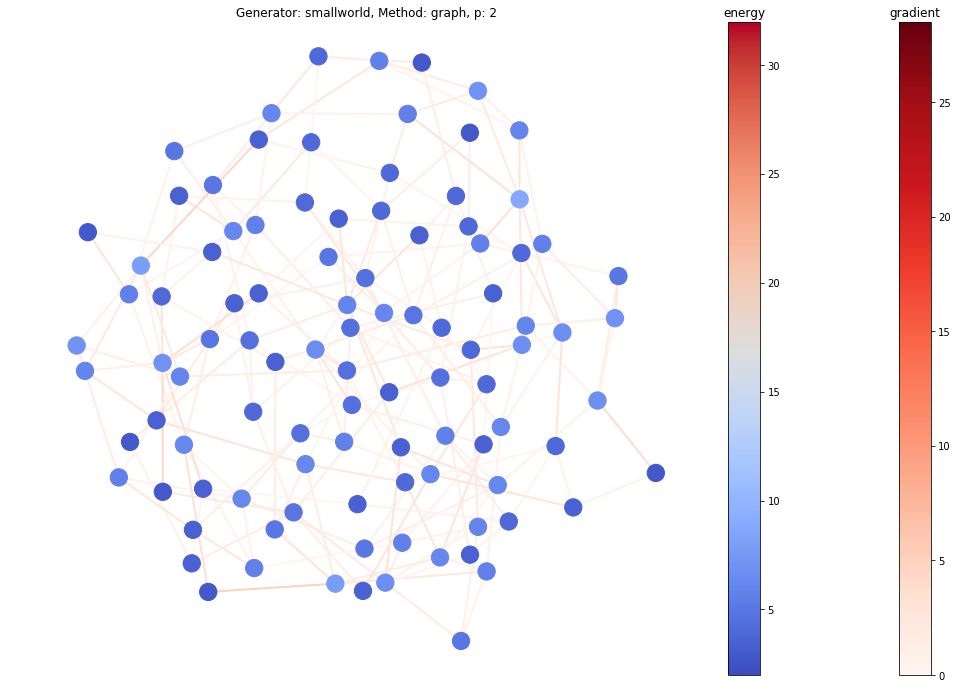

In [261]:
draw_network(2, 'smallworld', 'graph', 'p+method')

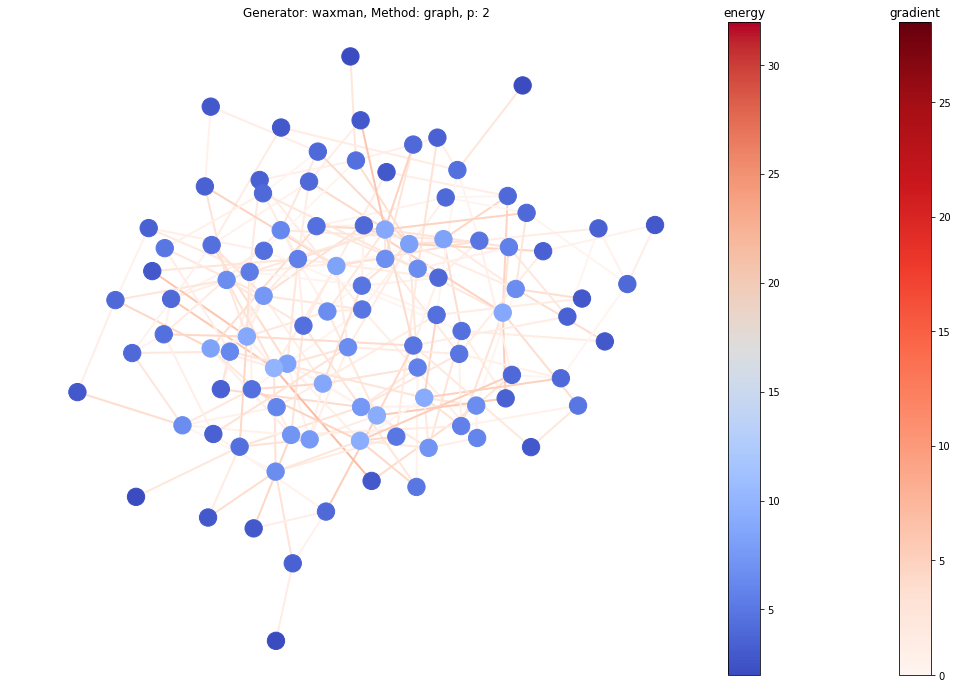

In [262]:
draw_network(2, 'waxman', 'graph', 'p+method')

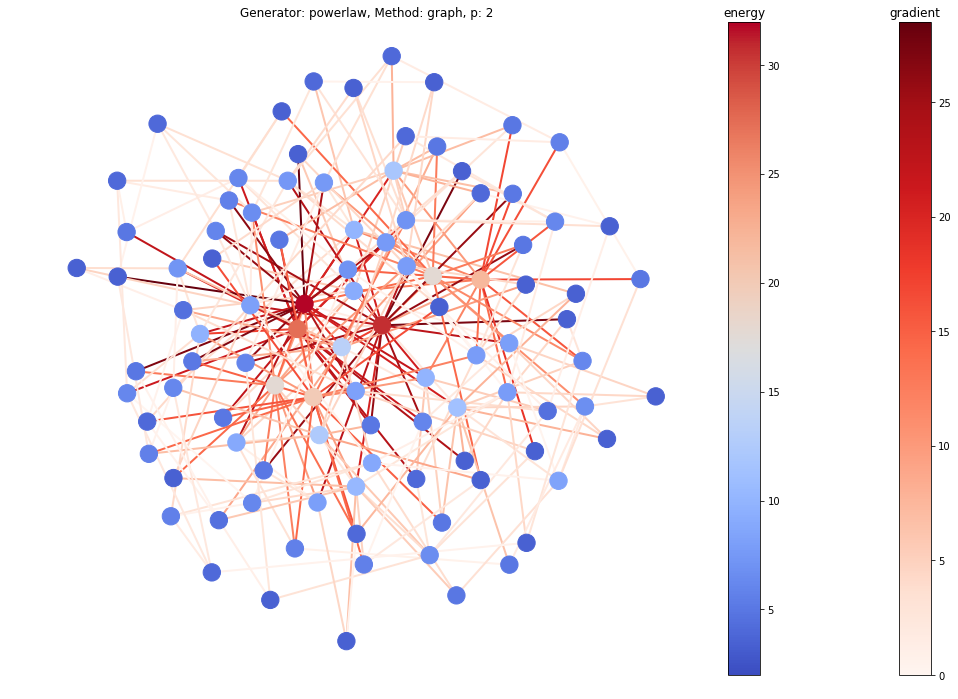

In [263]:
draw_network(2, 'powerlaw', 'graph', 'p+method')

### Visualization of laplacian energy and laplacian energy gradients in sythetic networks

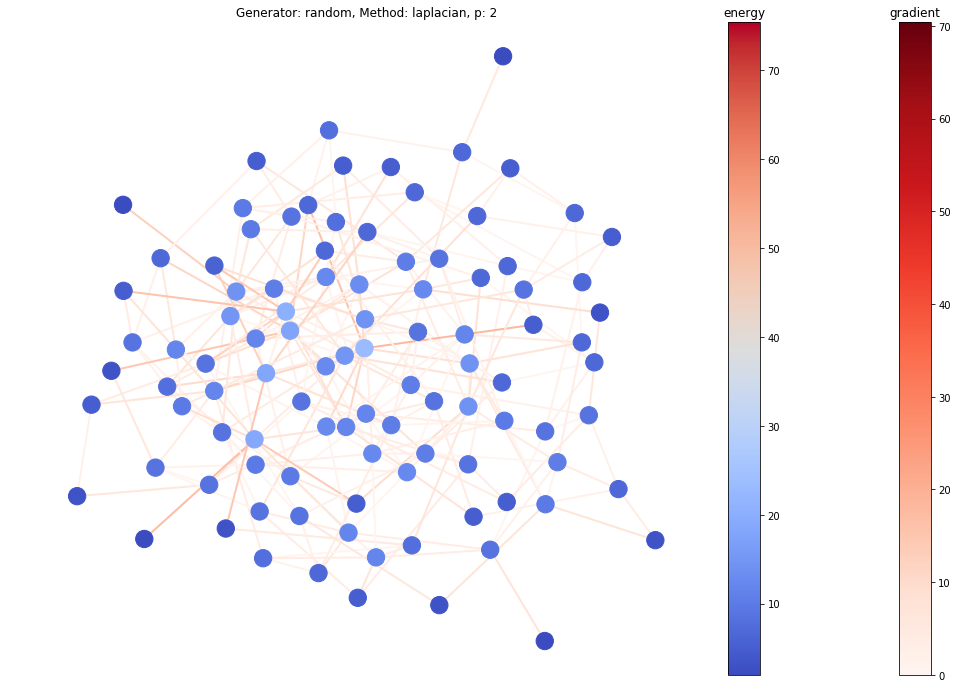

In [264]:
draw_network(2, 'random', 'laplacian', 'p+method')

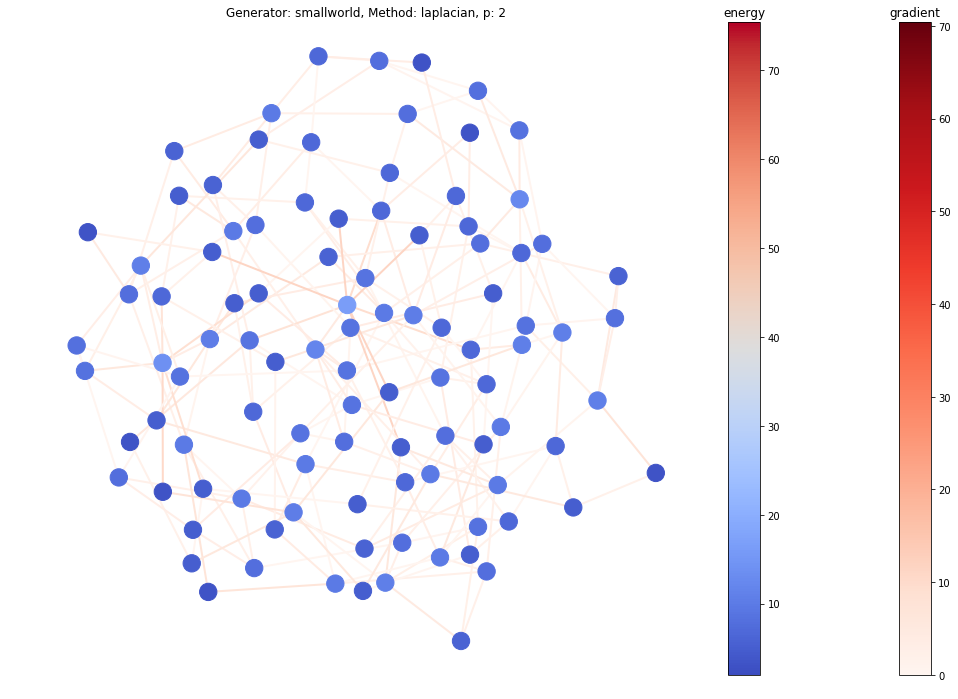

In [265]:
draw_network(2, 'smallworld', 'laplacian', 'p+method')

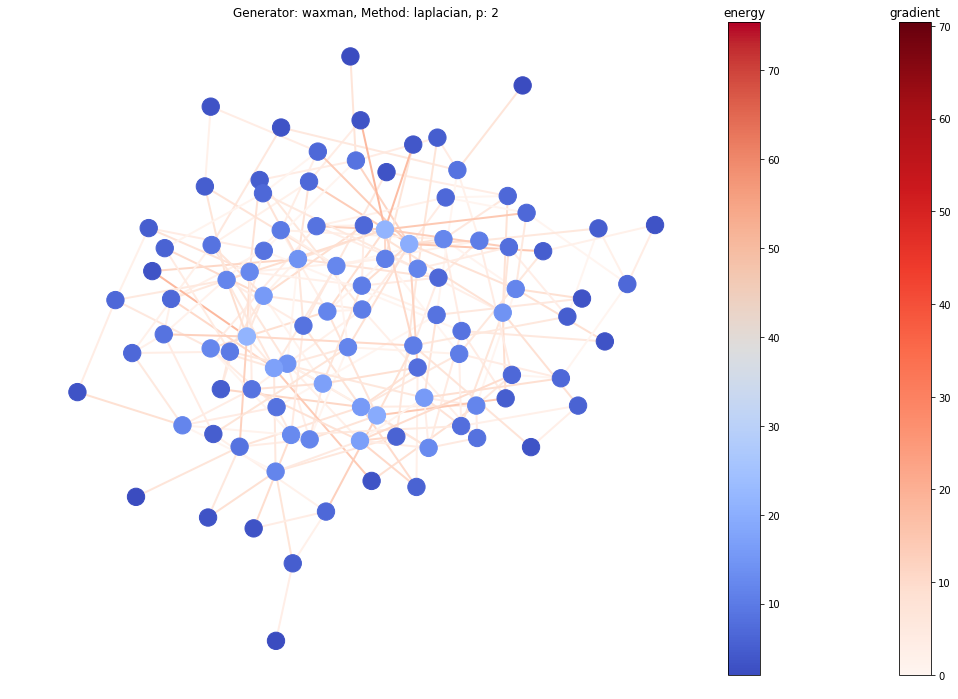

In [266]:
draw_network(2, 'waxman', 'laplacian', 'p+method')

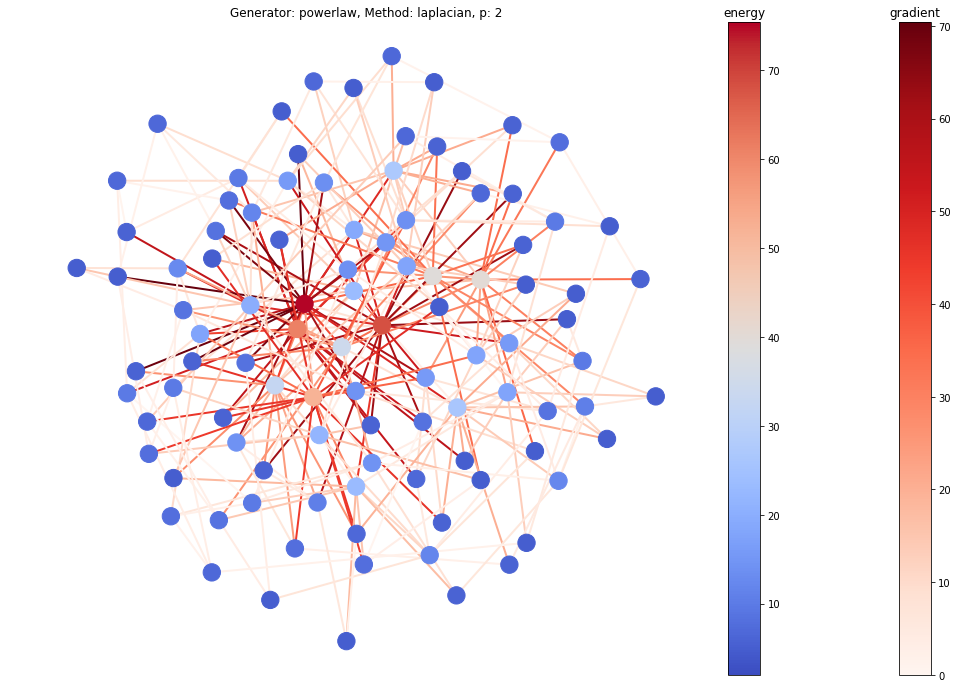

In [267]:
draw_network(2, 'powerlaw', 'laplacian', 'p+method')

### Visualization of laplacian energy and laplacian energy gradients in sythetic networks

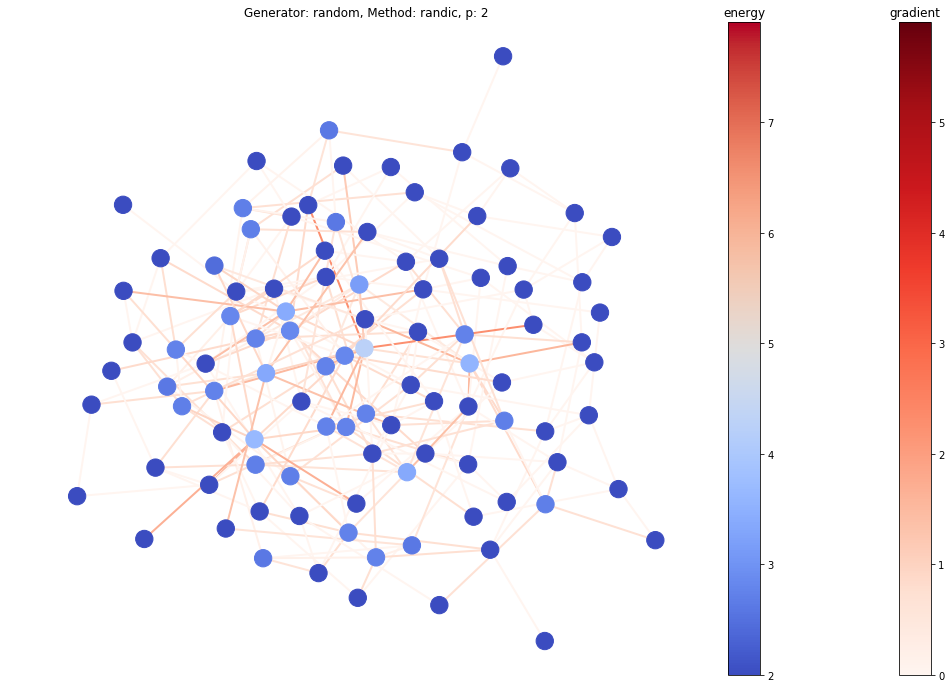

In [268]:
draw_network(2, 'random', 'randic', 'p+method')

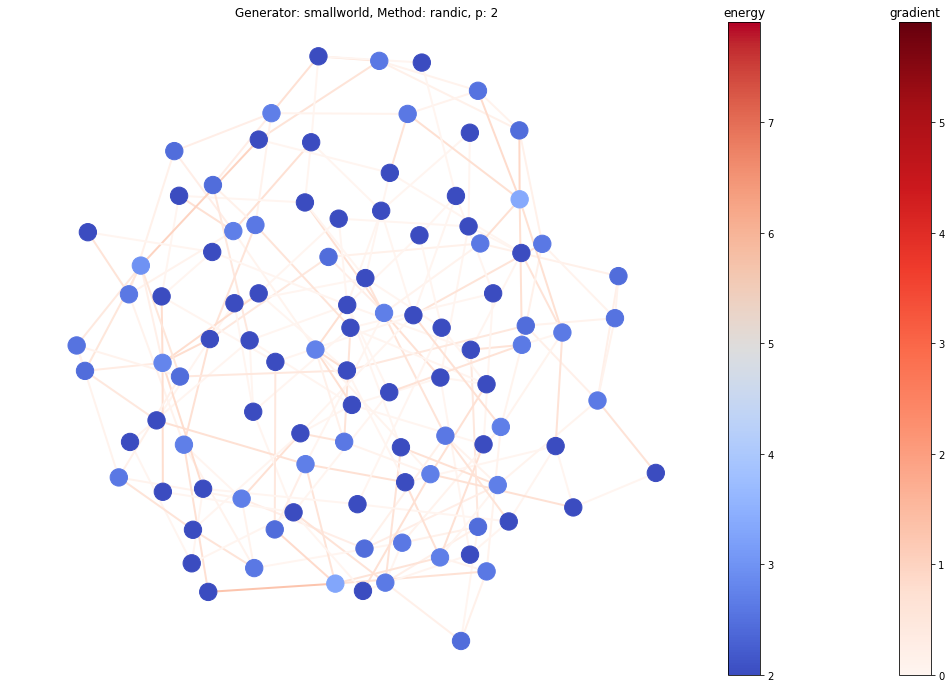

In [269]:
draw_network(2, 'smallworld', 'randic', 'p+method')

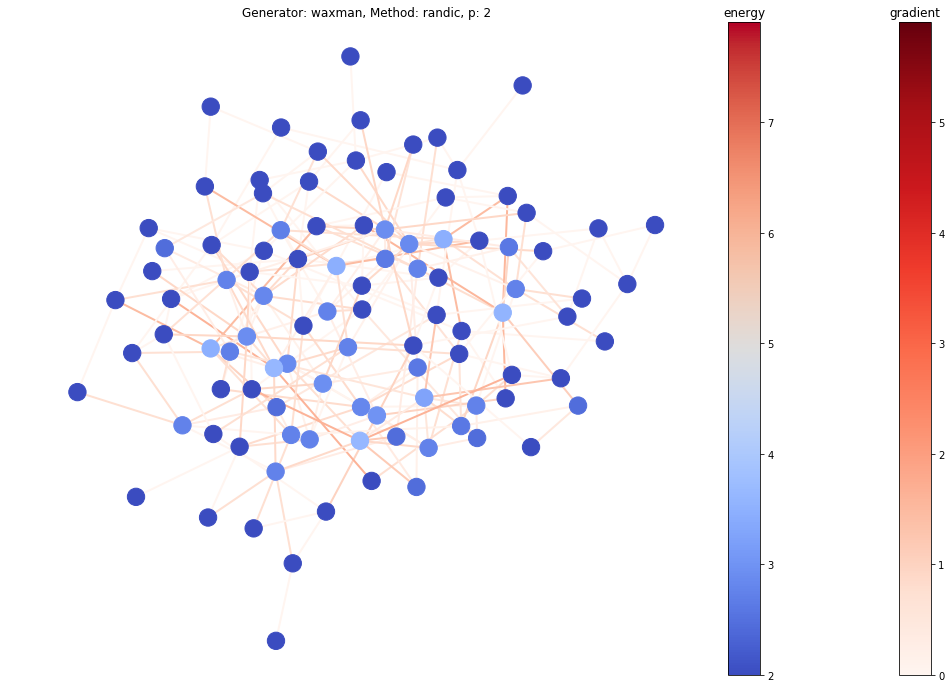

In [270]:
draw_network(2, 'waxman', 'randic', 'p+method')

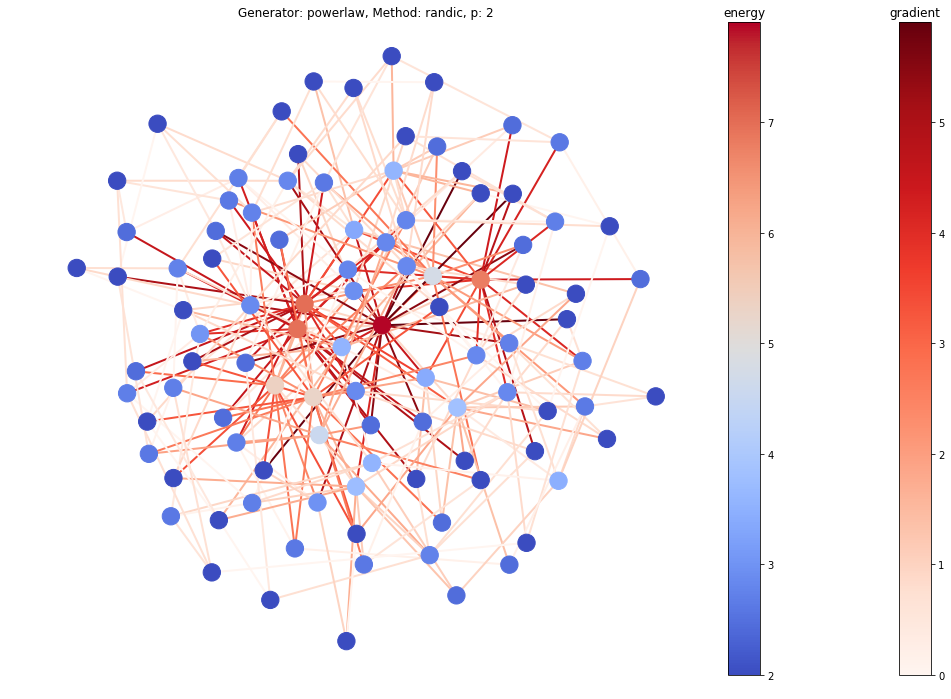

In [271]:
draw_network(2, 'powerlaw', 'randic', 'p+method')